# **GRUPO 1** - Trabajo Práctico Nuestras Caras

# Procesar fotos nuevas

In [1]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [3]:
import sys
import os
import pickle
import cv2
import numpy as np
import polars as pl
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt


PROYECTO_DIR = "/content/drive/MyDrive/DMA_Eigenfaces"
SRC_DIR = os.path.join(PROYECTO_DIR, "src")
MODELOS_DIR = os.path.join(PROYECTO_DIR, "modelos")

sys.path.append(SRC_DIR)

from procesar_imagenes import detectar_cara_dnn, cargar_face_detector, procesar_y_crear_dataset
from multiperceptron import multiperceptron


## **FUNCION PARA PROCESAR IMAGENES NUEVAS**

In [4]:
def procesar_imagenes_nuevas(
    input_folder: str,
    net: cv2.dnn_Net,
    img_size: Tuple[int, int] = (64, 64),
    confidence_threshold: float = 0.3
) -> pl.DataFrame:
    """
    Procesa imágenes nuevas no etiquetadas: detecta la cara, recorta, convierte a gris, resizea,
    y arma un DataFrame compatible con la red neuronal entrenada.

    Returns:
        Polars DataFrame con columnas: 'imagen' (array aplanado) y 'filename' (nombre de archivo)
    """
    imagenes = []
    nombres = []

    for file in sorted(os.listdir(input_folder)):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        path = os.path.join(input_folder, file)
        img = cv2.imread(path)
        if img is None:
            continue

        box = detectar_cara_dnn(img, net, confidence_threshold)
        if box is not None:
            x1, y1, x2, y2 = box

            # Añadir margen
            margin_ratio = 0.2
            bw, bh = x2 - x1, y2 - y1
            x1 = max(0, x1 - int(bw * margin_ratio))
            y1 = max(0, y1 - int(bh * margin_ratio))
            x2 = min(img.shape[1], x2 + int(bw * margin_ratio))
            y2 = min(img.shape[0], y2 + int(bh * margin_ratio))

            face_crop = img[y1:y2, x1:x2]
            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
            face_crop = cv2.resize(face_crop, img_size)
            imagenes.append(face_crop.flatten())
            nombres.append(file)

    df = pl.DataFrame({
        "filename": nombres,
        **{f"x{i+1}": [img[i] for img in imagenes] for i in range(img_size[0] * img_size[1])}
    })

    return df

CARGO EL OBJETO ISOMAP CON EL QUE REDUJE DIMENSIONES EN EL DATASET ORIGINAL

In [5]:
# Directorios

IMG_NUEVAS_DIR = os.path.join(PROYECTO_DIR, "imagenes/fotos_nuevas_2")
IMG_SIZE = (64, 64)

# Cargar Scaler e ISOMAP
with open(os.path.join(MODELOS_DIR, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)

with open(os.path.join(MODELOS_DIR, "isomap_10_10.pkl"), "rb") as f:
    isomap = pickle.load(f)



In [14]:
# Cargar e inicializar el multiperceptron

mp = multiperceptron()
mp.cargar_modelo(os.path.join(MODELOS_DIR, "red_GS3"))

(4000, np.float64(0.0021330037687878793), np.float64(0.016587677725118485))

In [7]:
net = cargar_face_detector()

df_nuevas = procesar_imagenes_nuevas(IMG_NUEVAS_DIR, net)


In [15]:
# 1. Convertir imágenes nuevas a matriz
X_nuevas = np.array(df_nuevas.select([f"x{i+1}" for i in range(64*64)]))

# 2. Escalar con el scaler que guardaste
X_nuevas_scaled = scaler.transform(X_nuevas)

# 3. Aplicar ISOMAP
X_nuevas_iso = isomap.transform(X_nuevas_scaled)

# 4. Convertir a DataFrame
df_nuevas_reducidas = pl.DataFrame({
    **{f"x{i+1}": X_nuevas_iso[:, i] for i in range(X_nuevas_iso.shape[1])}
})

In [16]:
df_nuevas_reducidas = df_nuevas_reducidas.with_columns(
    pl.Series("y", ["?"] * df_nuevas_reducidas.height)
)

In [17]:
#predecir
y_pred, y_raw, _ = mp.predecir(df_nuevas_reducidas, campos=[f"x{i+1}" for i in range(X_nuevas_iso.shape[1])], clase="y")


In [18]:
# Calculás la confianza
confianza_max = [max(vec) for vec in y_raw]

# Aplicás el umbral para detectar intrusos
umbral = 0.8
pred_final = ["intruso" if c < umbral else p for c, p in zip(confianza_max, y_pred)]

# Armás el DataFrame de resultados
df_resultado = pl.DataFrame({
    "filename": df_nuevas["filename"],
    "pred": y_pred,
    "confianza": confianza_max,
    "pred_final": pred_final
})

In [19]:
def mostrar_predicciones_con_imagenes(input_folder, df_resultado, columnas=5):
    filas = (len(df_resultado) + columnas - 1) // columnas
    plt.figure(figsize=(3 * columnas, 3.5 * filas))

    for i, row in enumerate(df_resultado.iter_rows(named=True)):
        filepath = os.path.join(input_folder, row["filename"])
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(filas, columnas, i + 1)
        plt.imshow(img)
        plt.title(f'{row["pred_final"]}\n({row["confianza"]:.2f})', fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

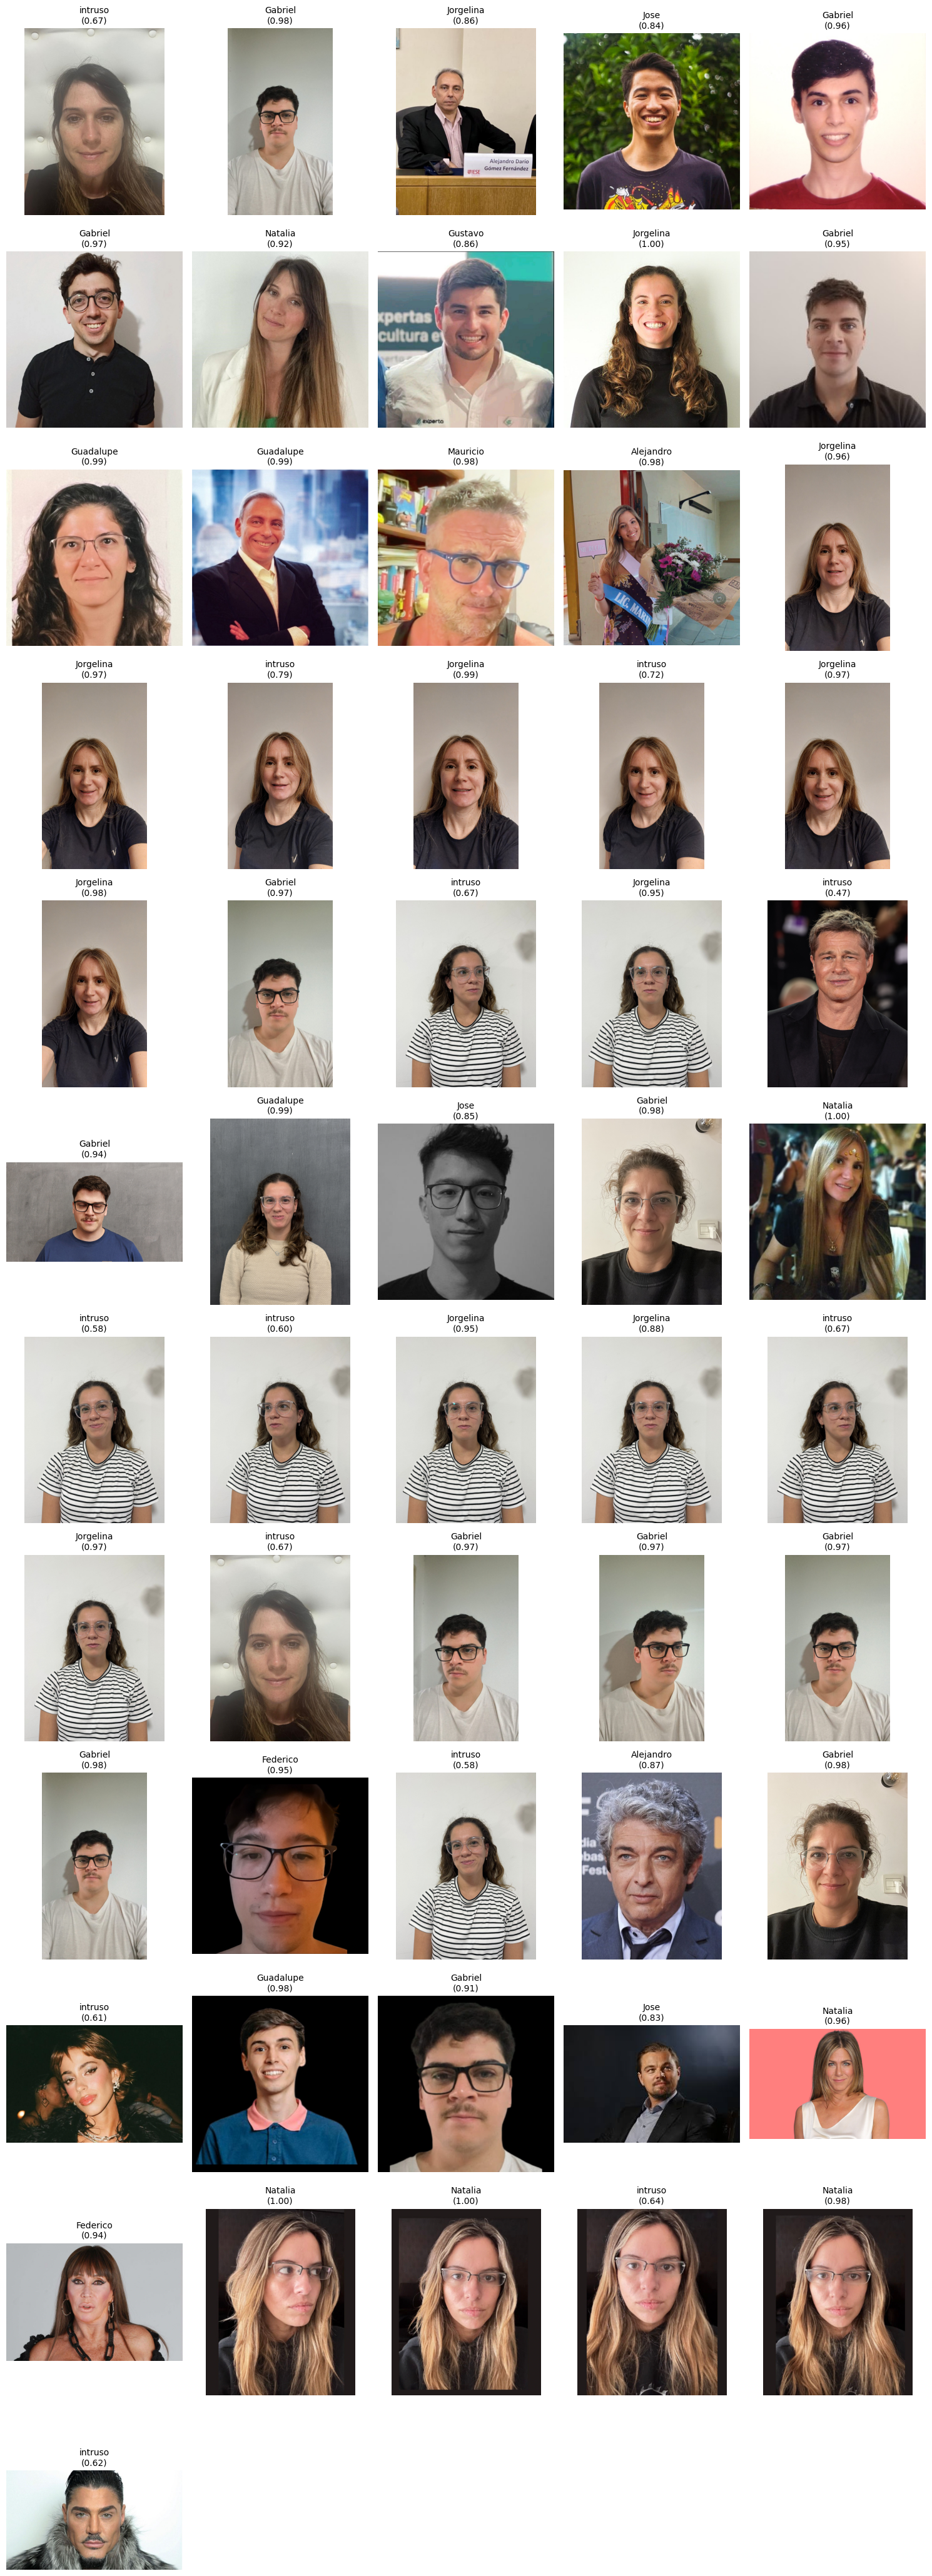

In [20]:
mostrar_predicciones_con_imagenes(IMG_NUEVAS_DIR, df_resultado)